In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy.units as u
import astropy.constants as const
import matplotlib as mpl

In [ ]:
# clrs = sns.color_palette('Set1')
# clrs[5] = (255/255, 200/255, 80/255)
# colors = cycler('color', list(clrs.as_hex()))
mpl.rc('font', family='serif')
# #mpl.rc('text', usetex=True)

plt.rc('axes', axisbelow=True, 
       grid=False)#, prop_cycle=colors)
plt.rc('xtick', direction='in')
plt.rc('ytick', direction='in')
plt.rcParams['figure.dpi'] = 150

# Convenience Functions

In [2]:
def radial_velocity(wavelengths, labline):
    velocity = (wavelengths - labline*u.AA)/(labline*u.AA) * const.c.to(u.km/u.s)
    return velocity

def gaussian(x, amp, sig, cen, bgl):
    x = np.array(x)
    y = amp * np.exp(-((x - cen)**2.0)/(2.0 * (sig**2.0))) + bgl
    return y

In [3]:
def make_gauss_from_params(x, params):
    if len(params) == 4:
        return gaussian(x, params['amp'][0], params['sig'][0], params['cen'][0], params['bgl'][0])
    if len(params) == 7:
        return [gaussian(x, params['amp1'][0], params['sig1'][0], params['cen1'][0], params['bgl'][0]), gaussian(x, params['amp2'][0], params['sig2'][0], params['cen2'][0], params['bgl'][0])]

# Read in Data

In [ ]:
line_df = pd.read_pickle(os.path.join('data', 'line_df_local.pkl'))
blue_df = pd.read_pickle(os.path.join('data', 'blue_df.pkl'))
red_df = pd.read_pickle(os.path.join('data', 'red_df.pkl'))

prog_df = pd.read_pickle(os.path.join('data', 'line_prog_df_local.pkl'))
blue_df = pd.read_pickle(os.path.join('data', 'blue_prog_df.pkl'))
red_df = pd.read_pickle(os.path.join('data', 'red_prog_df.pkl'))

In [5]:
def SNR(signal, noise):
    #normalize the signal
    normsignal = signal/np.max(signal)
    normnoise = noise/np.max(noise)
    return np.mean(normsignal/normnoise)

def snr_mask(df, low, high):
    ratio = df.apply(lambda r: SNR(r['gauss_flux'], r['gauss_fluxerr']) /
                               SNR(r['flux'], r['fluxerr']), axis=1)
    return df[ratio.between(low, high)]

red_df_cut  = snr_mask(red_df,  1.3, 13)
blue_df_cut = snr_mask(blue_df, 1.3, 16)
line_df_cut = snr_mask(line_df, 0.8, 100)

In [16]:
for i, param in enumerate(line_df.iloc[0]['params2']):
    print(i, param)

0 amp1
1 sig1
2 cen1
3 amp2
4 sig2
5 cen2
6 bgl


# Plot All fits

In [45]:
def plot_fits(df, transition, plot_vel=False):
    for _, row in df[df['transition']==transition].iterrows():
        flux = row['flux'].value
        fluxerr = row['fluxerr'].value
        wave = row['wavelength']#.value
        vel_data = radial_velocity(wave, row['labline']).value
        
        ygauss = row['gauss_flux'].value
        ygausserr = row['gauss_fluxerr'].value

        y2gauss = row['double_gauss_flux'].value
        y2gausserr = row['double_gauss_fluxerr'].value

        waveconv = row['conv_wavelength']#.value
        vel_conv = radial_velocity(waveconv, row['labline']).value
        
        fig, ax = plt.subplots(1,2, figsize = (9,5), layout='constrained')
        if plot_vel:
            ygauss1, ygauss2 = make_gauss_from_params(waveconv, row['params2'])

            ax[0].plot(vel_conv, ygauss, label='single conv gauss')
            ax[0].fill_between(vel_conv, ygauss-ygausserr, ygauss+ygausserr, color='red', alpha=0.4,)

            ax[0].plot(vel_data, flux, '--', label='emission line')
            ax[0].fill_between(vel_data, flux-fluxerr, flux+fluxerr, color='black', alpha=0.2)
            ax[1].plot(vel_data, flux, '--', label='emission line')
            ax[1].fill_between(vel_data, flux-fluxerr, flux+fluxerr, color='black', alpha=0.2)

            ax[1].plot(vel_conv, ygauss1, label='NC')
            ax[1].plot(vel_conv, ygauss2, label='BC')

            ax[0].set_title(f"BIC = {row['BIC1']}")
            ax[1].set_title(f"BIC = {row['BIC2']}")

            ax[1].plot(vel_conv, y2gauss, label='double conv gauss')
            ax[1].fill_between(vel_conv, y2gauss-y2gausserr, y2gauss+y2gausserr, color='red', alpha=0.4,)

            for i, param in enumerate(row['params2']):
                ax[1].text(0.05, 0.95-(i*0.05), f'{param} = {row['params2'][param][0]:0.2f}',
                                transform=ax[1].transAxes, verticalalignment='top')
            
            for i, param in enumerate(row['params1']):
                ax[0].text(0.05, 0.95-(i*0.05), f'{param} = {row['params1'][param][0]:0.2f}',
                                transform=ax[0].transAxes, verticalalignment='top')

            fig.supxlabel(r'Velocity (m s$^{-1}$)')
        else:
            ygauss1, ygauss2 = make_gauss_from_params(wave, row['params2'])

            ax[0].plot(waveconv.value, ygauss, label='single conv gauss')
            ax[0].fill_between(waveconv.value, ygauss-ygausserr, ygauss+ygausserr, color='red', alpha=0.4,)

            ax[0].plot(wave.value, flux, '--', label='emission line')
            ax[0].fill_between(wave.value, flux-fluxerr, flux+fluxerr, color='black', alpha=0.2)
            ax[1].plot(wave.value, flux, '--', label='emission line')
            ax[1].fill_between(wave.value, flux-fluxerr, flux+fluxerr, color='black', alpha=0.2)

            ax[1].plot(wave, ygauss1, label='NC')
            ax[1].plot(wave, ygauss2, label='BC')

            ax[0].set_title(f"BIC = {row['BIC1']}")
            ax[1].set_title(f"BIC = {row['BIC2']}")

            ax[1].plot(waveconv.value, y2gauss, label='double conv gauss')
            ax[1].fill_between(waveconv.value, y2gauss-y2gausserr, y2gauss+y2gausserr, color='red', alpha=0.4,)

            for i, param in enumerate(row['params2']):
                ax[1].text(0.05, 0.95-(i*0.05), f'{param} = {row['params2'][param][0]:0.2f}',
                                transform=ax[1].transAxes, verticalalignment='top')
            
            for i, param in enumerate(row['params1']):
                ax[0].text(0.05, 0.95-(i*0.05), f'{param} = {row['params1'][param][0]:0.2f}',
                                transform=ax[0].transAxes, verticalalignment='top')

            fig.supxlabel(r'Wavelength ($\AA$)')
            
        ax[0].legend()
        ax[1].legend()
        ax[0].set_ylabel(r'Flux ($erg \AA^{-1} s^{-2} cm^{-2}$)')
        fig.suptitle(f"{row['transition']} {row['labline']} {row['obsdate']}")
        plt.show()

In [ ]:
#cut low SNR fits
#make an SNR cut to remove lines whose fit errors are high. This ensures we keep good fits only.
#first, make the cut based on the single gauss fit. Cut if fit SNR < data SNR
def SNR(signal, noise):
    #normalize the signal
    normsignal = signal/np.max(signal)
    normnoise = noise/np.max(noise)
    return np.mean(normsignal/normnoise)

def snr_mask(df, low, high):
    ratio = df.apply(lambda r: SNR(r['gauss_flux'], r['gauss_fluxerr']) /
                               SNR(r['flux'], r['fluxerr']), axis=1)
    return df[ratio.between(low, high)]

red_df_cut  = snr_mask(red_df,  1.3, 13)
blue_df_cut = snr_mask(blue_df, 1.3, 16)
line_df_cut = snr_mask(line_df, 0.8, 100)

In [48]:
red_df['transition'].unique()

array(['[0,3]', '[2,12]'], dtype=object)

In [37]:
vsini = ((0.01/1431.01) * const.c.to(u.km/u.s)) #v sini
vsini/np.sin(19)

<Quantity 13.97791629 km / s>

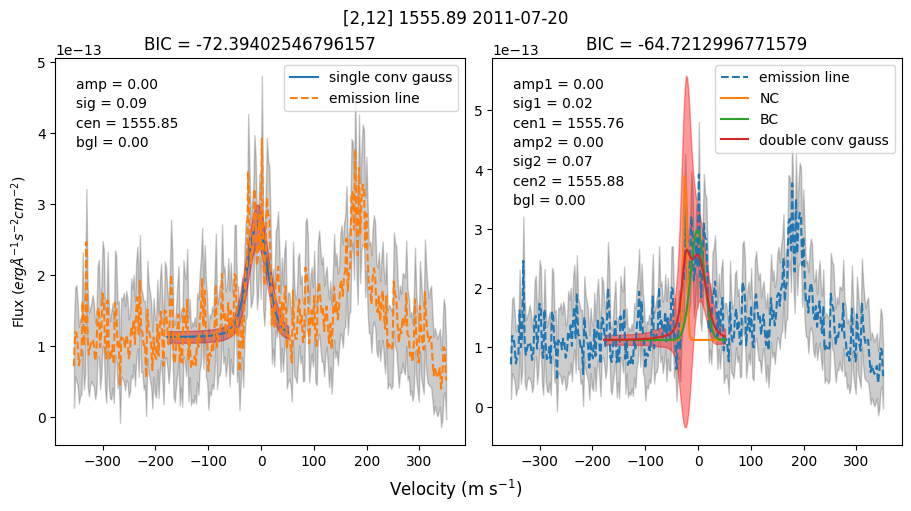

In [52]:
plot_fits(red_df, '[2,12]', plot_vel=True)

# Plot Coadded lines

In [ ]:
for transition_plot in ['[1,4]']:
    mask = prog_df['transition'] == transition_plot

    for _, row_prog in prog_df[mask].iterrows():
        fig, ax = plt.subplots(2, 2, figsize=(8, 6), sharex=True)
        fig.suptitle(row_prog['obsdate'] + ' ' + transition_plot)

        coadd_lines = line_df_cut[(line_df_cut['transition'] == transition_plot) & 
                              (line_df_cut['obsdate'] == row_prog['obsdate'])]

        #loop over original lines
        for _, row_line in coadd_lines.iterrows():
            velocity = radial_velocity(row_line['conv_wavelength'], row_line['labline'])

            # Single Gauss data
            ax[0, 0].plot(velocity, row_line['gauss_flux'], alpha=0.4, label=row_line['labline'])
            ax[0, 1].plot(velocity, row_line['gauss_flux']/row_line['gauss_fluxerr'], alpha=0.4)

            # Double Gauss data
            ax[1, 0].plot(velocity, row_line['double_gauss_flux'], alpha=0.4, label=row_line['labline'])
            ax[1, 1].plot(velocity, row_line['double_gauss_flux']/row_line['double_gauss_fluxerr'], alpha=0.4)

        #Single Gaussian Coadd
        ax[0, 0].plot(row_prog['coadded_velocity'], row_prog['single_coadded_flux'].value,
                      c='black', ls='--', lw=2, label='single coadd')
        ax[0, 0].fill_between(row_prog['coadded_velocity'].value, row_prog['single_coadded_flux'].value-row_prog['single_coadded_fluxerr'].value,
                              row_prog['single_coadded_flux'].value+row_prog['single_coadded_fluxerr'].value,
                      color='black', alpha=0.3)
        ax[0, 0].vlines(0, 0, 1.3e-12, 'r')
        ax[0, 1].plot(row_prog['coadded_velocity'],
                      row_prog['single_coadded_flux'].value / row_prog['single_coadded_fluxerr'].value,
                      c='black', ls='--', lw=2)

        # Double Gaussian Coadd
        ax[1, 0].plot(row_prog['coadded_velocity'], row_prog['double_coadded_flux'].value,
                      c='blue', ls='-', lw=2, label='double coadd')
        ax[1, 0].fill_between(row_prog['coadded_velocity'].value, row_prog['double_coadded_flux'].value-row_prog['double_coadded_fluxerr'].value,
                              row_prog['double_coadded_flux'].value+row_prog['double_coadded_fluxerr'].value,
                      color='blue', alpha=0.3)
        ax[1, 0].vlines(0, 0, 1.3e-12, 'r')
        ax[1, 1].plot(row_prog['coadded_velocity'],
                      row_prog['double_coadded_flux'].value / row_prog['double_coadded_fluxerr'].value,
                      c='blue', ls='-', lw=2)

        #Labels & Style
        for row in range(2):
            ax[row, 0].set_ylabel('Flux ' + u.format.Latex().to_string(row_prog['single_coadded_flux'].unit, fraction=False))
            ax[row, 0].set_ylim(0, 1e-12)
            ax[row, 0].set_xlim(-300, 300)
            ax[row, 0].legend(loc='lower right')
            ax[row, 0].text(0.05, 0.95, f'Num lines = {len(coadd_lines)}',
                            transform=ax[row, 0].transAxes, verticalalignment='top')

            ax[row, 1].set_ylabel('SNR')
            ax[row, 1].set_ylim(0, None)

        ax[1, 0].set_xlabel('Radial Velocity ' + u.format.Latex().to_string(row_prog['coadded_velocity'].unit, fraction=False))
        ax[1, 1].set_xlabel('Radial Velocity ' + u.format.Latex().to_string(row_prog['coadded_velocity'].unit, fraction=False))

        ax[0, 0].set_title('Single-Gaussian Coadd')
        ax[0, 1].set_title('Single-Gaussian SNR')
        ax[1, 0].set_title('Double-Gaussian Coadd')
        ax[1, 1].set_title('Double-Gaussian SNR')

        plt.tight_layout()
        plt.show()
